# MovieVerse

In [9]:
import pandas as pd
import sqlite3

In [12]:
conn = sqlite3.connect('/Users/ronnie/Documents/Flatiron/NYC_DS_112023/phase-2-project/zippedData/im.db')

In [4]:
pd.read_sql("""
SELECT name
FROM sqlite_master
WHERE type = "table"

""", conn)

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers
8,box_office_mojo
9,tn_movie_budgets


In [122]:
pd.read_sql("""
SELECT *
FROM movie_basics
LIMIT 5

""", conn)
#FROM tn_movie_budgets

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [133]:
# basics_budgets = pd.read_sql("""

# SELECT *
# FROM movie_basics AS m
# JOIN tn_movie_budgets AS t
#         ON m.primary_title = t.movie
# GROUP BY genres

# """, conn)

In [134]:
# basics_budgets = basics_budgets.explode('genres')

In [135]:
# basics_budgets

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,index,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0326592,The Overnight,The Overnight,2010,88.0,None,5620,21,"Jun 19, 2015",The Overnight,"$200,000","$1,109,808","$1,165,996"
1,tt10075374,The Little Prince,The Little Prince,2019,93.0,Action,618,19,"Feb 12, 2016",The Little Prince,"$77,500,000","$1,311,213","$102,028,919"
2,tt1460743,Reign of Assassins,Jian yu,2010,117.0,"Action,Adventure",3227,28,"Nov 1, 2016",Reign of Assassins,"$14,000,000",$0,"$11,354,230"
3,tt0448694,Puss in Boots,Puss in Boots,2011,90.0,"Action,Adventure,Animation",245,46,"Oct 28, 2011",Puss in Boots,"$130,000,000","$149,260,504","$554,987,477"
4,tt1390411,In the Heart of the Sea,In the Heart of the Sea,2015,122.0,"Action,Adventure,Biography",400,1,"Dec 11, 2015",In the Heart of the Sea,"$100,000,000","$25,020,758","$89,693,309"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,tt1836212,All Superheroes Must Die,All Superheroes Must Die,2011,78.0,"Sci-Fi,Thriller",5755,56,"Jan 4, 2013",All Superheroes Must Die,"$20,000",$0,$0
342,tt3779570,Won't Back Down,Won't Back Down,2014,114.0,Sport,2748,49,"Sep 28, 2012",Won't Back Down,"$19,000,000","$5,310,554","$5,745,503"
343,tt10109982,Miracle,Miracle,2019,NaN,Thriller,2044,45,"Feb 6, 2004",Miracle,"$28,000,000","$64,378,093","$64,474,705"
344,tt1891799,Exodus,Exodus,2011,151.0,War,4485,86,"Dec 15, 1960",Exodus,"$4,000,000","$21,750,000","$21,750,000"


In [127]:
pd.read_sql("""

SELECT m.genres,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                t.production_budget
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres
ORDER BY average_worldwide_gross DESC
LIMIT 5

""", conn)

,genres,average_worldwide_gross,production_budget
0,"Fantasy,Romance",1.272470e+09,"$150,000,000"
1,"Adventure,Drama,Sport",1.272470e+09,"$150,000,000"
2,"Family,Fantasy,Musical",9.338154e+08,"$160,000,000"
3,"Adventure,Fantasy",7.012107e+08,"$250,000,000"
4,"Action,Adventure,Sci-Fi",5.991302e+08,"$215,000,000"


In [52]:
genre_profit = pd.read_sql("""

SELECT m.genres,
                COUNT(m.genres) AS genre_count,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres
HAVING genre_count > 10
ORDER BY average_profit_perc DESC
LIMIT 25

""", conn)

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

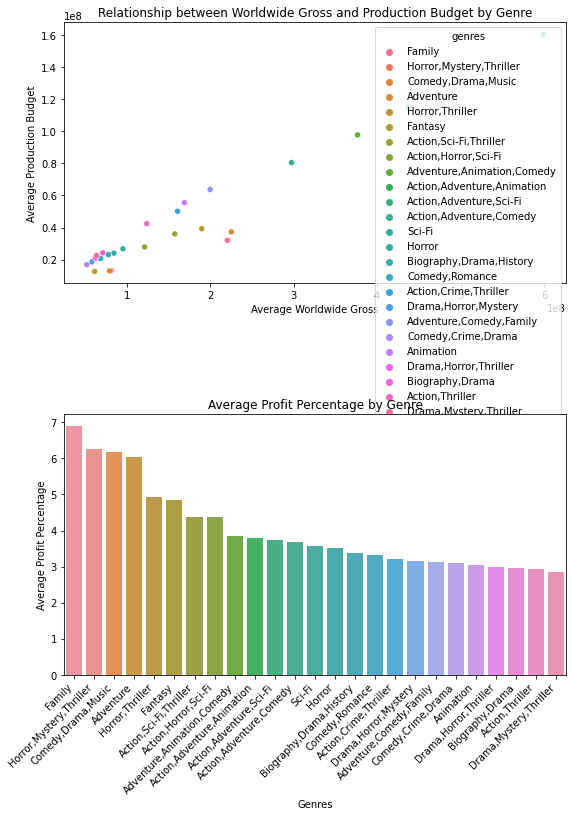

In [77]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between subplots

# Scatter plot
sns.scatterplot(x='average_worldwide_gross', y='average_production_budget', hue='genres', markers='genres', data=genre_profit, ax=ax1)
ax1.set_xlabel('Average Worldwide Gross')
ax1.set_ylabel('Average Production Budget')
ax1.set_title('Relationship between Worldwide Gross and Production Budget by Genre')

# Bar graph
sns.barplot(x='genres', y='average_profit_perc', data=genre_profit, ax=ax2)
ax2.set_xlabel('Genres')
ax2.set_ylabel('Average Profit Percentage')
ax2.set_title('Average Profit Percentage by Genre')

# Rotate the x-axis labels for better readability in the bar graph
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Show the plots
plt.show()

In [97]:
top_genres = pd.read_sql("""

SELECT 
    CASE 
        WHEN genres LIKE '%Action%' THEN 'Action'
        WHEN genres LIKE '%Adventure%' THEN 'Adventure'
        WHEN genres LIKE '%Horror%' THEN 'Horror'
        WHEN genres LIKE '%Family%' THEN 'Family'
        WHEN genres LIKE '%Comedy%' THEN 'Comedy'
        WHEN genres LIKE '%Animation%' THEN 'Animation'
        WHEN genres LIKE '%Thriller%' THEN 'Thriller'
        WHEN genres LIKE '%Sci-Fi%' THEN 'Sci-Fi'
        WHEN genres LIKE '%Fantasy%' THEN 'Fantasy'
        WHEN genres LIKE '%Drama%' THEN 'Drama'
        WHEN genres LIKE '%Mystery%' THEN 'Mystery'
        
        ELSE 'Other'
    END AS genres_sorted,
    SUM(CASE WHEN genres LIKE '%Action%' OR genres LIKE '%Adventure%' OR genres LIKE '%Horror%'  OR genres LIKE '%Family%'
                                     OR genres LIKE '%Comedy%' OR genres LIKE '%Animation%' OR genres LIKE '%Thriller%' OR genres LIKE '%Sci-Fi%' 
                                     OR genres LIKE '%Fantasy%' OR genres LIKE '%Drama%' OR genres LIKE '%Mystery%'
                                     THEN 1 ELSE 0 END) AS count,
     average_worldwide_gross,
     average_production_budget,
     average_profit_perc
FROM (SELECT m.genres,
                COUNT(m.genres) AS genre_count,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) AS average_worldwide_gross,
                AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_production_budget,
                AVG(CAST(REPLACE(REPLACE(t.worldwide_gross, '$', ''), ',', '') AS INT)) / AVG(CAST(REPLACE(REPLACE(t.production_budget, '$', ''), ',', '') AS INT)) AS average_profit_perc
FROM movie_basics AS m
JOIN tn_movie_budgets AS t
        ON m.primary_title = t.movie
GROUP BY genres

ORDER BY average_profit_perc DESC)
GROUP BY genres_sorted
ORDER BY average_profit_perc DESC;

""", conn)
top_genres

,genres_sorted,count,average_worldwide_gross,average_production_budget,average_profit_perc
0,Family,28,9.246274e+07,3244000.0,28.502695
1,Horror,34,9.512734e+07,3500000.0,27.179241
2,Thriller,23,3.516201e+08,18000000.0,19.534452
3,Fantasy,11,1.086101e+08,6530000.0,16.632484
4,Adventure,48,1.293142e+07,1000000.0,12.931420
5,Action,77,1.716858e+08,20000000.0,8.584290
6,Animation,7,4.182407e+07,5000000.0,8.364813
7,Other,0,8.115822e+07,10562500.0,7.683618
8,Comedy,40,2.938152e+08,40100000.0,7.327061
9,Drama,42,4.370000e+07,6000000.0,7.283333


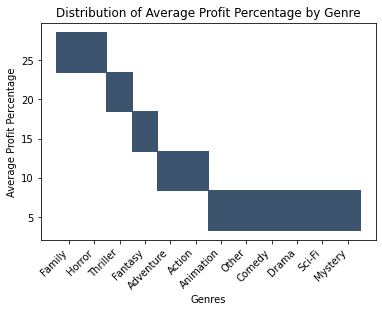

In [126]:
# Create the histogram
sns.histplot(data=top_genres, x = 'genres_sorted', y ='average_profit_perc')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Profit Percentage')
plt.title('Distribution of Average Profit Percentage by Genre')
plt.xticks(rotation=45, ha='right')
# Show the plot
plt.show()

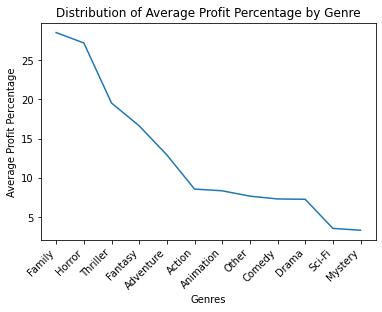

In [123]:
# Create the line graph
sns.lineplot(data=top_genres, x='genres_sorted', y='average_profit_perc')

# Add labels and title
plt.xlabel('Genres')
plt.ylabel('Average Profit Percentage')
plt.title('Distribution of Average Profit Percentage by Genre')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

We found that the top genres based on average profit percentage are family, horror and thriller.

2007 rows of Studio info without nulls

In [28]:
#STUDIO INFO
pd.read_sql("""
SELECT *
FROM box_office_mojo

""", conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2007 entries, 0 to 2006
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           2007 non-null   int64  
 1   title           2007 non-null   object 
 2   studio          2007 non-null   object 
 3   domestic_gross  2007 non-null   float64
 4   foreign_gross   2007 non-null   object 
 5   year            2007 non-null   int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 94.2+ KB


In [91]:
pd.read_sql("""
    SELECT *
    FROM box_office_mojo AS b
    JOIN tn_movie_budgets AS t
        ON b.title = t.movie
""", conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1083 entries, 0 to 1082
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   index              1083 non-null   int64  
 1   title              1083 non-null   object 
 2   studio             1083 non-null   object 
 3   domestic_gross     1083 non-null   float64
 4   foreign_gross      1083 non-null   object 
 5   year               1083 non-null   int64  
 6   index              1083 non-null   int64  
 7   id                 1083 non-null   int64  
 8   release_date       1083 non-null   object 
 9   movie              1083 non-null   object 
 10  production_budget  1083 non-null   object 
 11  domestic_gross     1083 non-null   object 
 12  worldwide_gross    1083 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 110.1+ KB


TOP COUNT BY STUDIO

In [86]:
pd.read_sql("""
    SELECT COUNT(title) AS total_count, studio,  production_budget, worldwide_gross
    FROM box_office_mojo AS b
    JOIN tn_movie_budgets AS t
        ON b.title = t.movie
        
    GROUP BY studio
    ORDER BY total_count DESC
    LIMIT 25
""", conn)

,total_count,studio,production_budget,worldwide_gross
0,117,Uni.,"$69,000,000","$543,464,573"
1,108,Fox,"$155,000,000","$418,186,950"
2,100,WB,"$160,000,000","$835,524,642"
3,74,Sony,"$40,000,000","$351,774,938"
4,72,Par.,"$170,000,000","$621,156,389"
5,70,BV,"$200,000,000","$1,068,879,522"
6,54,LGF,"$82,000,000","$268,268,174"
7,38,Wein.,"$1,000,000","$16,566,240"
8,36,WB (NL),"$95,000,000","$294,680,778"
9,36,FoxS,"$13,000,000","$331,266,710"


In [149]:
pd.read_sql("""
    SELECT COUNT(title) AS total_count, studio, production_budget, worldwide_gross
    FROM box_office_mojo AS b
    JOIN tn_movie_budgets AS t
        ON b.title = t.movie
    GROUP BY studio
    ORDER BY total_count ASC
    LIMIT 30
""", conn).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   total_count        30 non-null     int64 
 1   studio             30 non-null     object
 2   production_budget  30 non-null     object
 3   worldwide_gross    30 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB


In [148]:
pd.read_sql("""

WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 


SELECT COUNT(movie) AS family_movie_count, production_budget, year, studio
FROM split
JOIN movie_basics AS m
    ON instr(genres, genre) > 0
JOIN tn_movie_budgets AS t
    ON m.primary_title = t.movie
JOIN box_office_mojo AS b
    ON b.title = t.movie

WHERE genre ='Family' 

GROUP BY production_budget, year, studio
ORDER BY production_budget

LIMIT 25
""", conn)

#GROUP BY production_budget, year, studio
#ORDER BY production_budget
#SELECT COUNT(*) AS family_movie_count, production_budget, year, studio
#WITH RECURSIVE split(genre, str) AS (
#    SELECT '', genres || ',' FROM movie_basics
#    UNION ALL SELECT
#    substr(str, 0, instr(str, ',')),
#    substr(str, instr(str, ',')+1)
#    FROM split WHERE str!=''
#) 
#SELECT COUNT(*) AS family_movie_count, production_budget, year, studio
#FROM split
#JOIN movie_basics AS m
#    ON instr(genres, genre) > 0
#JOIN tn_movie_budgets AS t
#    ON m.primary_title = t.movie
#JOIN box_office_mojo AS b
#    ON b.title = t.movie
#WHERE genre ='Family' 
#GROUP BY production_budget, year, studio;

#graph won't work properly.. not sure why!

,family_movie_count,production_budget,year,studio
0,6227,"$10,000,000",2016,ORF
1,6227,"$10,100,000",2010,Eros
2,6227,"$100,000,000",2013,Fox
3,6227,"$103,000,000",2018,BV
4,6227,"$110,000,000",2011,BV
5,6227,"$112,000,000",2010,Fox
6,6227,"$127,000,000",2014,Fox
7,6227,"$13,000,000",2010,SPC
8,6227,"$13,000,000",2014,Rela.
9,6227,"$13,000,000",2016,TriS


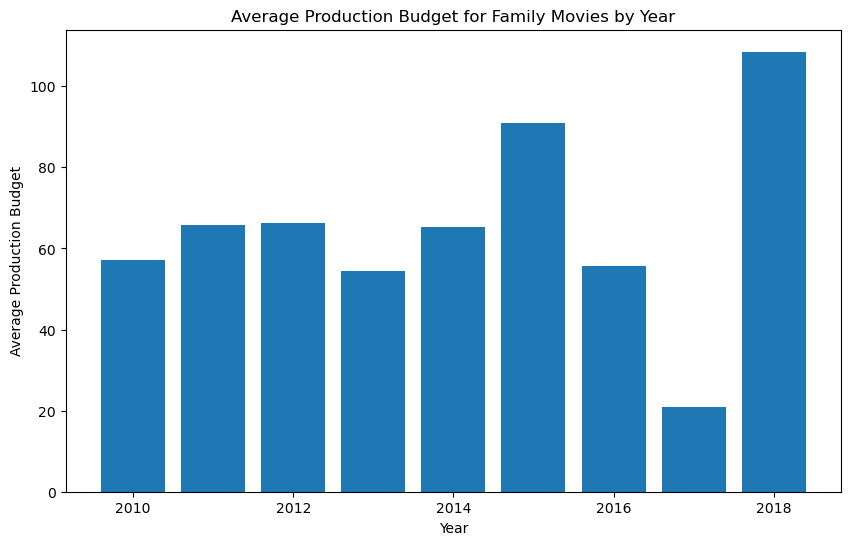

In [156]:
import matplotlib.pyplot as plt


df = pd.read_sql("""
WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 
SELECT AVG(CAST(REPLACE(production_budget, '$', '') AS INTEGER)) AS avg_production_budget, worldwide_gross
       year
FROM split
JOIN movie_basics AS m ON instr(genres, genre) > 0
JOIN tn_movie_budgets AS t ON m.primary_title = t.movie
JOIN box_office_mojo AS b ON b.title = t.movie
WHERE genre ='Family' 
GROUP BY year
ORDER BY year;
""", conn)


# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(df['year'], df['avg_production_budget'], )
plt.xlabel('Year')
plt.ylabel('Average Production Budget')
plt.title('Average Production Budget for Family Movies by Year')
plt.show()


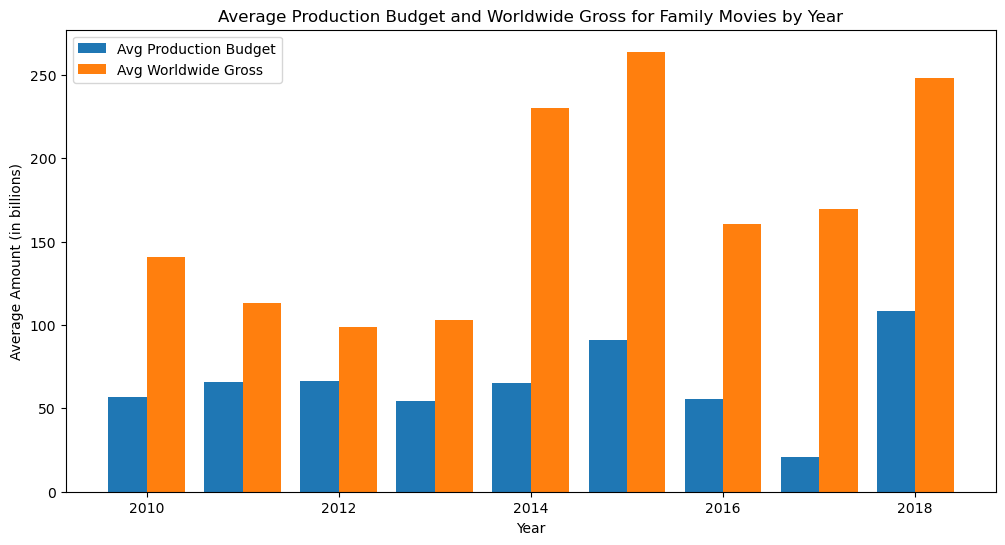

In [162]:
df = pd.read_sql("""
WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 
SELECT AVG(CAST(REPLACE(production_budget, '$', '') AS INTEGER)) AS avg_production_budget,
       AVG(CAST(REPLACE(worldwide_gross, '$', '') AS INTEGER)) AS avg_worldwide_gross,
       year
FROM split
JOIN movie_basics AS m ON instr(genres, genre) > 0
JOIN tn_movie_budgets AS t ON m.primary_title = t.movie
JOIN box_office_mojo AS b ON b.title = t.movie
WHERE genre ='Family' 
GROUP BY year
ORDER BY year;

""", conn)

# Plotting the data
plt.figure(figsize=(12, 6))

# Double bar graph
plt.bar(df['year'] - 0.2, df['avg_production_budget'], width=0.4, label='Avg Production Budget')
plt.bar(df['year'] + 0.2, df['avg_worldwide_gross'], width=0.4, label='Avg Worldwide Gross' )

plt.xlabel('Year')
plt.ylabel('Average Amount (in billions)')
plt.title('Average Production Budget and Worldwide Gross for Family Movies by Year')
plt.legend()
plt.show()


In [170]:
pd.read_sql("""
WITH RECURSIVE split(genre, str) AS (
    SELECT '', genres || ',' FROM movie_basics
    UNION ALL SELECT
    substr(str, 0, instr(str, ',')),
    substr(str, instr(str, ',')+1)
    FROM split WHERE str!=''
) 
SELECT studio,
       COUNT(*) AS total_movies,
       AVG(CAST(REPLACE(production_budget, '$', '') AS INTEGER)) AS avg_production_budget,
       AVG(CAST(REPLACE(worldwide_gross, '$', '') AS INTEGER)) AS avg_worldwide_gross
FROM (
    SELECT studio,
           CAST(REPLACE(production_budget, '$', '') AS INTEGER) AS production_budget,
           CAST(REPLACE(worldwide_gross, '$', '') AS INTEGER) AS worldwide_gross
    FROM split
    JOIN movie_basics AS m ON instr(genres, genre) > 0
    JOIN tn_movie_budgets AS t ON m.primary_title = t.movie
    JOIN box_office_mojo AS b ON b.title = t.movie
    WHERE genre ='Family' 
) AS filtered_data
GROUP BY studio
ORDER BY total_movies ASC;  -- Optionally, order by total movies in descending order



""", conn)

,studio,total_movies,avg_production_budget,avg_worldwide_gross
0,Eros,6227,10.000000,18.000000
1,Focus,6227,15.000000,59.000000
2,FoxS,6227,17.000000,7.000000
3,Free,6227,90.000000,20.000000
4,ORF,6227,10.000000,4.000000
5,Rela.,6227,13.000000,42.000000
6,SPC,6227,13.000000,11.000000
7,Studio 8,6227,51.000000,99.000000
8,Sum.,6227,35.000000,39.000000
9,Viv.,6227,3.000000,3.000000
